## 05. More statistics
**21 March 2025 by MiniUFO**

---
[TOC]

---
### 1. Introduction
Previously, we have shown how to calculate the relative dispersion.  Here we are going to show more dispersion measures, like kurtosis, which is also a time-based measure.  In addition, we also calculate some of the separation-based measures.

---

### 2. Calculation
#### 2.1 load the GLAD dataset and get original pairs

In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../../../')
from xdispersion import RelativeDispersion

drifters = xr.open_dataset('../../../data/glad32.nc')

rd = RelativeDispersion(drifters, maxtlen=4*24*85, ragged=True, ID='traj',
                        xpos='longitude', uvel='ve', time='time', Rearth=6371.2,
                        ypos='latitude' , vvel='vn', coord='latlon')

pairs = rd.get_all_pairs()

# filter original pairs from all pairs
origin_pairs = rd.get_original_pairs(pairs, r0=[0.08, 0.18])
origin_pairs

there are 43518 pairs of particles


<xarray.Dataset>
Dimensions:   (pair: 171, particle: 2)
Coordinates:
  * pair      (pair) int32 5716 6266 6539 7083 7883 ... 43389 43396 43425 43463
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) int32 3557 3142 3759 1999 3661 ... 2872 1314 4296 8039 3514
    stim      (pair) datetime64[ns] 2012-07-22T12:45:00 ... 2012-07-22T16:30:00
    r0        (pair) float32 0.08872 0.18 0.09602 ... 0.1259 0.09732 0.08311
    pID       (pair, particle) int32 20 21 22 23 23 24 ... 281 282 283 285 286
    xpos0     (pair, particle) float32 -88.2 -88.2 -88.2 ... -88.09 -88.08
    ypos0     (pair, particle) float32 28.8 28.8 28.8 28.8 ... 27.89 28.84 28.84
    idxI      (pair, particle) int32 121691 125248 134108 ... 1556133 1559647
    idxJ      (pair, particle) int32 130550 134107 137250 ... 1559647 1563161

#### 2.2 Extract building blocks for various measures
There are some basic separation and velocity measures, which serves as building blocks for calculating dispersion measures.  First we get all these building blocks.  These measures are of the same shape.


In [2]:
r, rx, ry, rxy = rd.separation_measures(origin_pairs) # separations of different components
du, dv, dul, dut, vmi, vmj, uv = rd.velocity_measures(origin_pairs) # velocities of different components

r

<xarray.DataArray (pair: 171, rtime: 8160)>
array([[-0.03727249, -0.03727207, -0.03727171, ...,         nan,
                nan,         nan],
       [ 0.1344485 ,  0.12712547,  0.12179948, ...,         nan,
                nan,         nan],
       [-0.05724094, -0.05058436, -0.04459359, ...,         nan,
                nan,         nan],
       ...,
       [-0.12162554, -0.14044395, -0.15321504, ...,         nan,
                nan,         nan],
       [-0.01141171, -0.01006916, -0.01074045, ...,         nan,
                nan,         nan],
       [-0.04124975, -0.03526131, -0.0299384 , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * pair     (pair) int32 5716 6266 6539 7083 7883 ... 43389 43396 43425 43463
  * rtime    (rtime) float64 0.0 0.01042 0.02083 0.03125 ... 84.97 84.98 84.99

#### 2.3 Calculate time-based measures using `xdisperison.measures`

Now we could calculate many measures using `xdispersion.measures`.  This wraps the calculation and bootstrapping into a single function call.  First for time-based measures, which are eventually plotted against time.

In [3]:
from xdispersion.measures import *

mean_at = 'const-t'

r2_t   = rel_disp(r, order=2, mean_at=mean_at)
S2_t   = vel_struct_func(np.hypot(du, dv), r, mean_at=mean_at)
S2ll_t = vel_struct_func(dul, r, mean_at=mean_at)
S2tr_t = vel_struct_func(dut, r, mean_at=mean_at)
S3_t   = vel_struct_func(dul*(du**2+dv**2), r, order=1, mean_at=mean_at)
ku_t   = kurtosis(r, mean_at=mean_at)
FAGR_t = cen_vul_exp(r, mean_at=mean_at)

Now we can plot the kurtosis, and see an overshoot which may be an indicator of nonlocal (Lundgren) dispersion behavior.

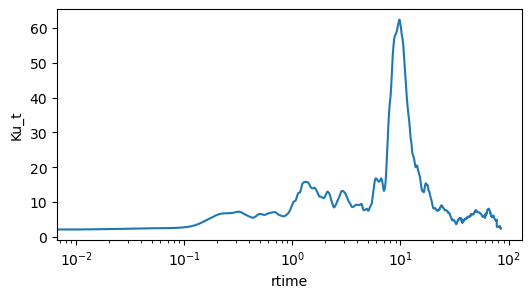

In [4]:
_ = ku_t.plot(xscale='log', figsize=(6, 3))

Note that we could bootstrapping by specifying a positive `ensemble` keyward argument.  By default, it is zero, which means no bootstrapping.  If it is set to a positive integer, boostrapping will be done and lower and upper bounds of errorbar will be returned.

In [5]:
ku_t, lower, upper = kurtosis(r, mean_at=mean_at, ensemble=1000)

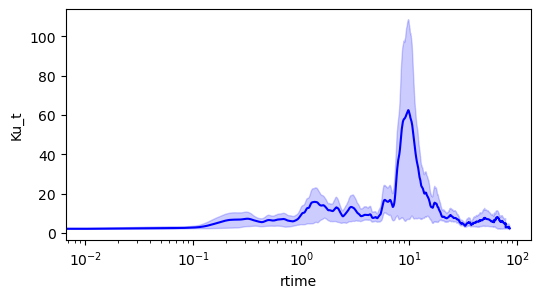

In [6]:
import matplotlib.pyplot as plt

ku_t.plot(xscale='log', figsize=(6, 3), c='b')
plt.fill_between(ku_t.rtime, lower, upper, alpha=0.2, color='b')

#### 2.4 Calculate separation-based measures using `xdisperison.measures`

All measures can be averaged at constant separation, instead of time.  These are then separation-based measures.

In [7]:
from xdispersion.measures import *
from xdispersion.utils import gen_rbins

mean_at = 'const-r'
# generate a set of separation bins rbins(n) = r0 * alpha**n
rbins = gen_rbins(0.1, 1000, alpha=1.2)

r2_r   = rel_disp(r, order=2, mean_at=mean_at, rbins=rbins)
S2_r   = vel_struct_func(np.hypot(du, dv), r, mean_at=mean_at, rbins=rbins)
S2ll_r = vel_struct_func(dul, r, mean_at=mean_at, rbins=rbins)
S2tr_r = vel_struct_func(dut, r, mean_at=mean_at, rbins=rbins)
S3_r   = vel_struct_func(dul*(du**2+dv**2), r, order=1, mean_at=mean_at, rbins=rbins)
ku_r   = kurtosis(r, mean_at=mean_at, rbins=rbins)
FAGR_r = famp_growth_rate(r, mean_at=mean_at, rbins=rbins)

/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


Now we plot the velocity structure functions.

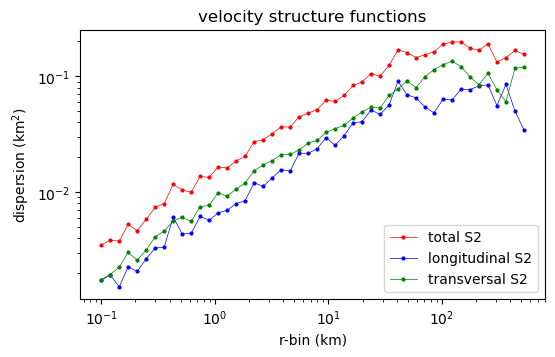

In [8]:
import matplotlib.pyplot as plt

m1 = S2_r.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1, label='total S2')
m2 = S2ll_r.plot(marker='o', color='b', markersize=2, lw=0.5, zorder=1, label='longitudinal S2')
m3 = S2tr_r.plot(marker='o', color='g', markersize=2, lw=0.5, zorder=1, label='transversal S2')
plt.legend([m1[0].get_label(), m2[0].get_label(), m3[0].get_label()], loc='lower right')
plt.title('velocity structure functions')
plt.xlabel('r-bin (km)')
_ = plt.ylabel('dispersion (km$^2$)')

We could also decompose the structure function into rotational and divergent components:

In [9]:
from xdispersion import rotational_divergent_components

S2rr, S2dd = rotational_divergent_components(S2ll_r, S2tr_r)

Plot this decomposition.

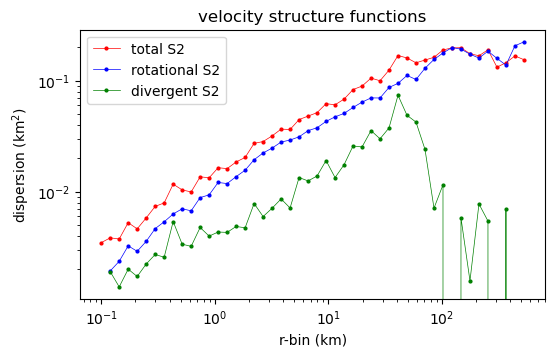

In [10]:
import matplotlib.pyplot as plt

m1 = S2_r.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1, label='total S2')
m2 = S2rr.plot(marker='o', color='b', markersize=2, lw=0.5, zorder=1, label='rotational S2')
m3 = S2dd.plot(marker='o', color='g', markersize=2, lw=0.5, zorder=1, label='divergent S2')
plt.legend([m1[0].get_label(), m2[0].get_label(), m3[0].get_label()], loc='upper left')
plt.title('velocity structure functions')
plt.xlabel('r-bin (km)')
_ = plt.ylabel('dispersion (km$^2$)')

In [11]:
FAGR_r, upper, lower = famp_growth_rate(r, mean_at=mean_at, rbins=rbins, ensemble=1000)

/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ur

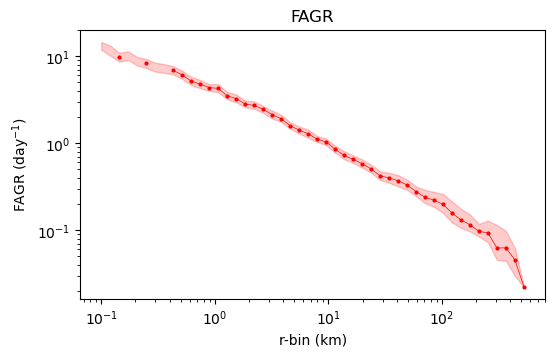

In [12]:
import matplotlib.pyplot as plt

FAGR_r.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1, label='total S2')
plt.fill_between(FAGR_r.rbin, upper, lower, alpha=0.2, color='r', zorder=-5)
plt.title('FAGR')
plt.xlabel('r-bin (km)')
_ = plt.ylabel('FAGR (day$^{-1}$)')

### 3. Conclusions

The time-based and separation-based measures are generally not the same, as they are averaged at constant time and constant separation, respectively.